# Motive / Optitrack to OpenEphys alignment
Assumes a TTL from Motive to OpenEphys at the start of each recording. If it doesn't find that, will try to align by timestamps.

IMPORTANT NOTE: Watch out for any warnings about start time having "second precision" when creating the `sync_df` DataFrame below, this will percolate through to all synchronized devices.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
from pathlib import Path

sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy/'])  # Add path to NeuroPy repository here
sys.path.extend(['/data/GitHub/NeuroPy/'])

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.optitrackio import OptitrackIO
import neuropy.io.openephysio as oeio
from neuropy.core.epoch import Epoch

## Load in session data and Open Ephys timestamps

In [2]:
dir_use = Path("/data3/Psilocybin/Recording_Rats/Finn/2022_02_17_psilocybin/")
sess = core.ProcessData(dir_use)

# Create sync_df to ID start and end of each recording in concatenated .eeg file
sync_df = oeio.create_sync_df(dir_use)

# Get absolute time from start of first recording
sync_df['Tabs from start (s)'] = (sync_df['Datetime'] - sync_df['Datetime'].iloc[0]).dt.total_seconds()
sync_df

start time = 2022-02-17 10:33:51.810584-05:00
start time = 2022-02-17 10:45:04.949076-05:00
start time = 2022-02-17 11:44:40.100407-05:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time,Tabs from start (s)
0,0,2022-02-17 10:33:51.810584-05:00,start,0,0.000000,0,0.0000,0.000000
1,0,2022-02-17 10:39:00.589217333-05:00,stop,9263359,308.778633,385973,308.7784,308.778633
2,1,2022-02-17 10:45:04.949076-05:00,start,9263360,308.778667,385974,308.7792,673.138492
3,1,2022-02-17 11:43:54.805042667-05:00,stop,115159039,3838.634633,4798293,3838.6344,4202.994459
4,2,2022-02-17 11:44:40.100407-05:00,start,115159040,3838.634667,4798294,3838.6352,4248.289823
5,2,2022-02-17 13:24:56.424640333-05:00,stop,295648767,9854.958900,12318698,9854.9584,10264.614056


## Next get OptiTrack recording start

### Method 1: Calculate from .tak file modification time and # frames in .avi file(no rigid body tracking or .csv file, ~millisecond precision?).

This method is used for synchronizing below...

In [3]:
from datetime import datetime
from neuropy.io.dlcio import DLC
import os
tak_file_dir = Path("/run/media/nkinsky/LWD_Backup/Nat/Psilocybin/Recording_Rats/Finn/2022_02_17_psilocybin/")
dlc_file_dir = Path("/data3/Psilocybin/Recording_Rats/Finn/2022_02_17_psilocybin/")
tak_files = sorted(tak_file_dir.glob("**/*.tak"))

mtimes = []
for tak_file in tak_files:
    mtimes.append(pd.Timestamp(datetime.fromtimestamp(os.path.getmtime(tak_file))))

dlc = DLC(dlc_file_dir)

opti_sr = dlc.SampleRate
mtimes

Using tracking file #0: /data3/Psilocybin/Recording_Rats/Finn/2022_02_17_psilocybin/1_baseline/Take 2022-02-17 10.33.54 AM-Camera 4 (#410110)DLC_resnet50_Psilocybin_DLCFeb13shuffle1_500000.h5
Using tracking file #1: /data3/Psilocybin/Recording_Rats/Finn/2022_02_17_psilocybin/2_psilocybin/Take 2022-02-17 10.45.11 AM-Camera 4 (#410110)DLC_resnet50_Psilocybin_DLCFeb13shuffle1_500000.h5
Multiple videos found - taking mean sample rate from all videos


[Timestamp('2022-02-17 13:24:52.349000')]

In [4]:
from neuropy.io.movie import tracking_movie
tz = "America/Detroit"
start_times = []
for tak_file, mtime in zip(tak_files, mtimes):
    try:
        movie_file = sorted(tak_file.parent.glob(f"{tak_file.stem}*.avi"))[0]
        mobj = tracking_movie(str(movie_file))
        start_times.append((mtime - pd.Timedelta(mobj.nframes / dlc.SampleRate, unit="sec")).tz_localize(tz))
    except IndexError:
        start_times.append(np.nan)

start_times

[Timestamp('2022-02-17 10:45:12.649000-0500', tz='America/Detroit')]

In [57]:
start_time_df = pd.DataFrame({"file": [tak_file.stem for tak_file in tak_files], 
                              "mod_time": mtimes,
                              "inferred_start_time": start_times,
                              "Opti_Recording": np.arange(len(tak_files))})

start_time_df.to_csv(sess.basepath / "inferred_start_time.csv")
start_time_df

,file,mod_time,inferred_start_time,Opti_Recording
0,Take 2022-02-17 10.45.11 AM,2022-02-17 13:24:52.349,2022-02-17 10:45:12.649000-05:00,0


In [58]:
# Manually insert # frames and sample rate for file above
start_time_df["SampleRate"] = dlc.SampleRate
start_time_df["nframes"] = dlc.nframes[1] # 

start_time_df.to_csv(sess.basepath / "inferred_start_time.csv")
start_time_df

,file,mod_time,inferred_start_time,Opti_Recording,SampleRate,nframes
0,Take 2022-02-17 10.45.11 AM,2022-02-17 13:24:52.349,2022-02-17 10:45:12.649000-05:00,0,30.0,287391


### Method 2: From .csv file output from .tak file (microsecond precision)
Note that lag from start time logged in .tak file to actual recording start time can be ~1.5 seconds.  

Not used below.

In [7]:
csv_path = "/data2/Alternation/Recording_Rats/Finn/2022_02_01_alternation2/1_alternation/"
opti = OptitrackIO(csv_path)
tstart_from_csv = opti.datetime_array[0]
tstart_from_csv

/data2/Alternation/Recording_Rats/Finn/2022_02_01_alternation2/1_alternation/Take 2022-02-01 11.42.46 AM.csv


Timestamp('2022-02-01 11:42:47.565000')

## Method 1: Motive start triggers some TTLs (but not all) at start only.
Example: Motive start triggers miniscope data acquisition which delivers a TTL for each frame acquired. Therefore the start of a TTL block can coincide with a Motive recording start, but in case of a disconnect we may a miniscope recording restart without restarting Motive.

In [55]:
# Load in ALL TTLs
ttl_start_chan_use = 1
ttl_df = oeio.load_all_ttl_events(dir_use)
ttl_df = ttl_df[ttl_df.channel_states.abs() == ttl_start_chan_use]
ttl_df[ttl_df.Recording == 0]

,channel_states,timestamps,datetimes,sample_number,event_name,Recording
0,-1,82316,2022-02-17 10:33:54.554450667-05:00,82316,,0
1,1,84406,2022-02-17 10:33:54.624117333-05:00,84406,,0
2,-1,86359,2022-02-17 10:33:54.689217333-05:00,86359,,0
3,1,88384,2022-02-17 10:33:54.756717333-05:00,88384,,0
4,-1,90431,2022-02-17 10:33:54.824950667-05:00,90431,,0
...,...,...,...,...,...,...
4451,1,9079331,2022-02-17 10:38:54.454950667-05:00,9079331,,0
4452,-1,9081369,2022-02-17 10:38:54.522884-05:00,9081369,,0
4453,1,9083374,2022-02-17 10:38:54.589717333-05:00,9083374,,0
4454,-1,9085398,2022-02-17 10:38:54.657184-05:00,9085398,,0


In [60]:
# Workhorse code to align each motive recording to each corresponding block of TTLs in OE.
# Start times of each OptiTrack recording in combined eeg time are accurate, but we will need to re-align any
# portions of Optitrack recordings that bridge two or more OE recording below.

buffer_sec = 1 # time buffer in seconds for start / stop detection
oe_sr = 30000  # OpenEphys sample rate
buffer_td = pd.Timedelta(buffer_sec, unit="sec")

opti_times_df = []
for idr, row in start_time_df.iterrows():
    
    # First grab timestamp for Optitrack/Motive recording start
    opti_start = row["inferred_start_time"]
    
    # Next ID ephys recording start based on closest TTL to start
    rec_bool = ((sync_df[sync_df.Condition == "start"]["Datetime"] - buffer_td)  < opti_start).values & ((sync_df[sync_df.Condition == "stop"]["Datetime"] + buffer_td) > opti_start).values
    oe_rec_num_use = sync_df[sync_df.Condition == "start"][rec_bool]["Recording"].iloc[0]
    oe_rec_num_use
    
    # Grab ttls from specific recording
    ttl_rec = ttl_df[ttl_df.Recording == oe_rec_num_use]
    
    oe_start_inds = np.where((ttl_rec["timestamps"].diff() > (buffer_sec * oe_sr)) |  np.isnan(ttl_rec["timestamps"].diff()))[0]
    start_ind = oe_start_inds[np.where((ttl_rec.iloc[oe_start_inds]["datetimes"] - opti_start).dt.total_seconds().abs() < buffer_sec)[0]]
    assert len(start_ind) == 1, "multiple candidate start times found in OE TTLs, adjust buffers and try again"
    start_ttl = ttl_rec.iloc[start_ind[0]]
    
    # Print stuff to screen as sanity check
    # print(f"MS start = {ms_start_ts}")
    # print(f"Corresponding TTL time in OE = {start_ttl['datetimes']}")

    # Calculate delta between miniscope time start and ttl received in OE
    start_delta = start_ttl['datetimes'] - opti_start
    # print(f"start_delta_sec={start_delta.total_seconds()}")

    # Now adjust each timestamp in miniscope timestamps by start offset from OE TTL 
    prior_oe_rec_start_dt = sync_df[(sync_df.Recording == oe_rec_num_use) & (sync_df.Condition == "start")].iloc[0]["Datetime"]
    prior_oe_rec_start_comb_time = sync_df[(sync_df.Recording == oe_rec_num_use) & (sync_df.Condition == "start")].iloc[0]["eeg_time"]
    opti_ts = pd.Series(row["inferred_start_time"] +  pd.to_timedelta(np.arange(row["nframes"])/row["SampleRate"], unit='s'))
    opti_times_eeg_align = pd.DataFrame({"Timestamps":(opti_ts + start_delta - prior_oe_rec_start_dt).dt.total_seconds() + prior_oe_rec_start_comb_time})
    
    # Save recording number
    opti_times_eeg_align["Opti_Recording"] = row["Opti_Recording"]
    
    opti_times_df.append(opti_times_eeg_align)

# Get output times of all miniscope timestamps now referenced to the concatenated eeg time.
opti_ts_align_df = pd.concat(opti_times_df, axis=0)
opti_ts_align_df

,Timestamps,Opti_Recording
0,316.502633,0
1,316.535967,0
2,316.569300,0
3,316.602633,0
4,316.635967,0
...,...,...
287386,9896.035967,0
287387,9896.069300,0
287388,9896.102633,0
287389,9896.135967,0


### Fix any Motive times that extend across two recordings

In [191]:
from copy import deepcopy
opti_ts_realign_df = []
for opti_rec in opti_ts_align_df["Opti_Recording"].unique():

    # Get Optitrack times for nth recoding 
    opti_times_eeg_realign = opti_ts_align_df[opti_ts_align_df["Opti_Recording"] == opti_rec]
    
    # Get optitrack start in absolute time from eeg start after aligning to concatenate eeg time
    opti_start_abs = np.interp(opti_times_eeg_realign["Timestamps"].loc[0], 
                               sync_df["eeg_time"], sync_df["Tabs from start (s)"])
    
    # Calculate delta to add to all timestamps in optitrack to get absolute time since OE recording start 
    opti_abs_delta = opti_start_abs - opti_times_eeg_realign["Timestamps"].loc[0]

    # Convert all Optritrack times to absolute time from EEG start
    opti_abs_times = opti_times_eeg_realign["Timestamps"] + opti_abs_delta
    opti_times_eeg_realign["Tabs_from_eeg_start"] = opti_abs_times

    # Identify OE recording for each absolute timestamp
    tabs_oe_starts = sync_df[sync_df.Condition == "start"]["Tabs from start (s)"]
    tabs_oe_stops = sync_df[sync_df.Condition == "stop"]["Tabs from start (s)"]

    oe_rec_by_start = np.digitize(opti_abs_times, tabs_oe_starts) - 1
    oe_rec_by_stop = np.digitize(opti_abs_times, tabs_oe_stops)

    # Loop through times corresponding to each OE recording and re-align to concatenate EEG
    for oe_rec in np.unique(np.hstack((oe_rec_by_start, oe_rec_by_stop))):
        
         # Tag optitrack frames by their corresponding OE recording
        oe_rec_bool = (oe_rec_by_start == oe_rec) & (oe_rec_by_stop == oe_rec) 
        opti_times_eeg_align.loc[oe_rec_bool, "OE_Recording"] = oe_rec
    
        # Interpolate Optitrack timestamps to concatenated EEG for each OpenEphys recording
        opti_interp = np.interp(opti_abs_times[oe_rec_bool], sync_df["Tabs from start (s)"], sync_df["eeg_time"])
        opti_times_eeg_realign.loc[oe_rec_bool, "Timestamps_realigned"] = opti_interp
    
    opti_ts_realign_df.append(opti_times_eeg_realign)

opti_ts_realign_df = pd.concat(opti_ts_realign_df, axis=0).drop(columns="Timestamps")
opti_ts_realign_df

,Opti_Recording,OE_Recording,Tabs_from_eeg_start,Timestamps_realigned
0,0,1.0,680.861927,316.502633
1,0,1.0,680.895260,316.535967
2,0,1.0,680.928594,316.569300
3,0,1.0,680.961927,316.602633
4,0,1.0,680.995260,316.635967
...,...,...,...,...
287386,0,2.0,10260.395260,9850.739605
287387,0,2.0,10260.428594,9850.772938
287388,0,2.0,10260.461927,9850.806271
287389,0,2.0,10260.495260,9850.839605


In [187]:
opti_ts_realign_df[np.isnan(opti_ts_realign_df.OE_Recording)]

,Timestamps,Opti_Recording,OE_Recording,Timestamps_realigned
105664,3838.635967,0,NaN,NaN
105665,3838.669300,0,NaN,NaN
105666,3838.702633,0,NaN,NaN
105667,3838.735967,0,NaN,NaN
105668,3838.769300,0,NaN,NaN
...,...,...,...,...
107018,3883.769300,0,NaN,NaN
107019,3883.802633,0,NaN,NaN
107020,3883.835967,0,NaN,NaN
107021,3883.869300,0,NaN,NaN


In [189]:
opti_abs_times[np.isnan(opti_ts_realign_df.OE_Recording)]

105664    4202.995260
105665    4203.028594
105666    4203.061927
105667    4203.095260
105668    4203.128594
             ...     
107018    4248.128594
107019    4248.161927
107020    4248.195260
107021    4248.228594
107022    4248.261927
Name: Timestamps, Length: 1359, dtype: float64

### Sanity check plots

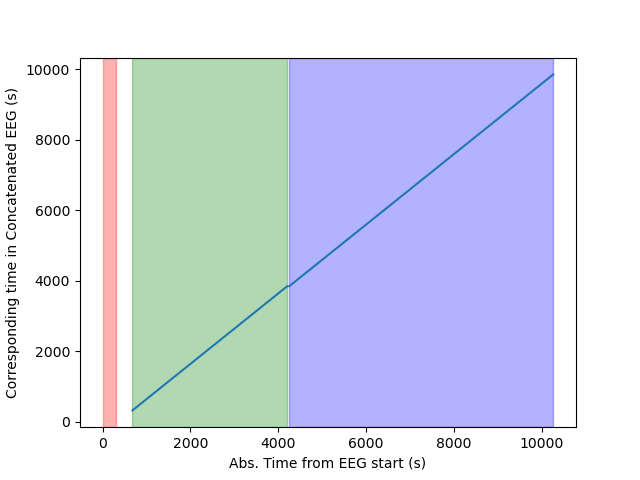

In [196]:
# Plot concatenate EEG timestamps vs absolute time from experiment start with each OE recording overlaid in different colors
_, ax = plt.subplots()
ax.plot(opti_ts_realign_df["Tabs_from_eeg_start"], opti_ts_realign_df["Timestamps_realigned"])
ax.set_xlabel("Abs. Time from EEG start (s)")
ax.set_ylabel("Corresponding time in Concatenated EEG (s)")

colors = ['r', 'g', 'b', 'c']*4
for oe_rec in sync_df.Recording.unique():
    oe_rec_df = sync_df[sync_df.Recording == oe_rec]
    oe_start, oe_stop = oe_rec_df["Tabs from start (s)"].values
    ax.axvspan(oe_start, oe_stop, alpha=0.3, color=colors[int(oe_rec)])


#### NRK TODO: add in similar plot showing multiple OptiTrack recordings

### If above looks ok, then adjust dataframe and save.

Horizontal gaps should occur if you have an optitrack recording that spans two OE recordings, e.g. if OE had a disconnect but Motive ran throughout.

Diagonal gaps should occur if you started and stopped both Motive and OE in the same period.

In [197]:
opti_ts_realign_df = opti_ts_realign_df.rename(columns={"Timestamps": "abs_time_from_eeg_start", 
                                                        "Timestamps_realigned": "eeg_aligned_times"})
opti_ts_realign_df.to_csv(sess.filePrefix.with_suffix(".opti_times_aligned.csv"))
np.save(sess.filePrefix.with_suffix(".opti_times_aligned.npy"), opti_ts_realign_df, allow_pickle=True)